# TOMAS Basics

**Authors:** Qiuyu Lian, Ziqi Rong

In this tutorial, we introduce how to harness doublets to infer the total mRNA ratio between two cell types with `TOMAS`.

We use the powerful data structure [AnnData](https://anndata.readthedocs.io/en/latest/#) to support basic operations of scRNA-seq data.

In [1]:
import tomas as tm
import scanpy as sc
import pickle
import numpy as np
import pandas as pd
import copy

The droplet labels are stored in `adata.obs`. In the basic case with two biological cell types, there should be at least three categories of droplets, including two kinds of homotypic droplets named as `Homo-cell-type-1` and `Homo-cell-type-2`, and one category of heterotypic doublets named as `Hetero-dbl`. 

In [5]:
adata = sc.read_h5ad('./tomas/datasets/Tcells_sparse.h5ad')
adata.obs.head(3)


,danno
AAACCCAAGACGCCAA-1,Homo-naive
AAACCCAAGACTTCAC-1,Homo-naive
AAACCCACAAGTAGTA-1,Homo-naive


In [3]:
np.unique(adata.obs['danno'],return_counts=True)

(array(['Hetero-dbl', 'Homo-activated', 'Homo-naive'], dtype=object),
 array([1446, 8076, 8414]))

Display UMI amount distribution.

In [4]:
adata.obs['total_UMIs'] = np.ravel(adata.X.sum(1))
adata.obs['log10_totUMIs'] = np.log10(adata.obs['total_UMIs'])


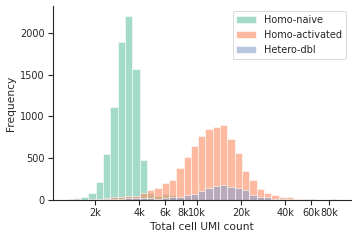

In [5]:
tm.vis.UMI_hist(adata,
                x_hist='log10_totUMIs',
                groupby='danno',
                show_groups=['Homo-naive','Homo-activated','Hetero-dbl'])


Potential evidence of capture rate decay. 

If all droplets shared the same capture rate or the same distribution of capture rate, the UMI amount per droplet would be proportational to the mRNA content within the droplet. So total UMI ratio should meet `Hetero-dbl`(`Naive T`+`Activated T`) :`Naive` = 1 + `Activated`:`Naive`. However, the observation below shows that `Hetero-dbl`(`Naive T`+`Activated T`) :`Naive` < 1 + `Activated`:`Naive`, contradicting the assumption. A reasonable explanation is that the capture rate decreases with the increasing of mRNA amount within a droplet.

In [6]:
tm.fit.logN_para(adata,
                 logNby='log10_totUMIs',
                 groupby='danno',
                 groups=['Homo-naive','Homo-activated','Hetero-dbl'],
                 inplace=True,
                 datatype='raw',
                 prt=True)


With raw UMIs, total UMI ratio of
	Homo-activated : Homo-naive = 3.753
	Hetero-dbl(Homo-activated+Homo-naive): Homo-naive = 4.087


## Fit Dirichlet-Multinomial (DMN) Model

Fit Dirichlet-Multinomial (DMN) model each kind of homo-typic droplet populations. The optimizated paremeters `Alpha` of each cell types is stroed in `adata.varm['para_diri']` as a `pandas.DataFrame`. 

In [8]:
tm.fit.dmn(adata,
           groupby='danno',
           groups=['Homo-naive','Homo-activated'], 
           c_version=True,
           subset=100,
           output='./tomas/output/Tcells')#'./prepareForRepo/re_test/alpha_subdata_1h')
'''
def test():
    print('Fit dmn with Homo-naive droplets. This may take a long time. Please wait...')
    print('Time cost: 3076.150367975235 seconds.')
    print('Fit dmn with Homo-activated droplets. This may take a long time. Please wait...')
    print('Time cost: 1396.546553850174 seconds.')
    
test()
alpha_df = pd.read_csv('./tomas/output/Tcells/alpha.csv',index_col=0)
adata.varm['para_diri'] = alpha_df
'''

Fit dmn with Homo-naive droplets. This may take a long time. Please wait...
Time cost: 3076.150367975235 seconds.
Fit dmn with Homo-activated droplets. This may take a long time. Please wait...
Time cost: 1396.546553850174 seconds.


Inspect the convergence

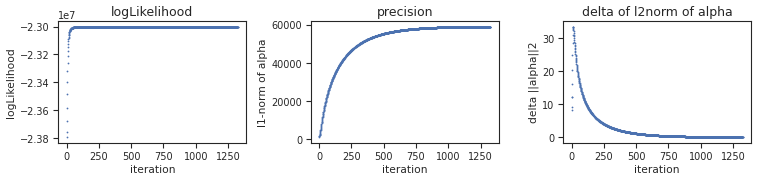

In [9]:
tm.vis.dmn_convergence('Homo-naive',output='./tomas/output/Tcells')#'./prepareForRepo/re_test/alpha_subdata_1h')


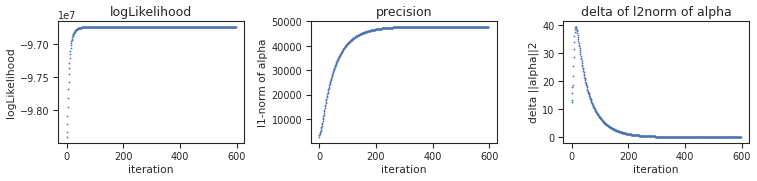

In [10]:
tm.vis.dmn_convergence('Homo-activated',output='./tomas/output/Tcells')#'./prepareForRepo/re_test/alpha_subdata_1h')


## Merge genes into exclusive meta-genes

We fuse a bunch of genes into a meta-gene to mitigate the curse of dimensionality. Metagenes are required to be informative to deconvolute doublets. To achive this goal, we first measure individual genes at differentialte two cell types with KL_divergence. This step might take several minutes.  

In [11]:
tm.auxi.cal_KL_bc(adata,groups=['Homo-naive','Homo-activated'])
adata

AnnData object with n_obs × n_vars = 17936 × 19303
    obs: 'danno', 'total_UMIs', 'log10_totUMIs'
    uns: 'raw_logUMI_para'
    varm: 'para_diri', 'kl'

Below are steps to obtain meta-genes:

1. Rank genes according to its expression exclusiveness. In the 2D space defined by Alpha1 and Alpha2, the Dirichlet parameters of cell type 1 and cell type 2 respectively, the extent of exclusiveness of a gene i is defiend as the cosine distance between its alpha coordinate (Alpha1_i, Alpha2_i) and the diagnoal line. A small cosine distance means that either Alpha1_i or Alpha2_i is close to zero. In other words, an exclusive gene tends to be highly expressed in one cell type and be silendt in another cell type.   
2. Classify genes into cell-type-1-specific and cell-type-2-specific groups. Genes with Alpha1_i greater than Alpha2_i is considered to be cell-type-1-specific, and vice versa. 
3. Merge genes and keep the exclusiveness ASAP. Choose one cell-type-1-specific gene and one cell-type-2-specific gene with smallest cosine values as metagene seeds to start merging. For each metagene, absorb genes iteratively from the same ordered cell-type-specific gene list. Once the alpha sum of the metagene exceeds a threshold, a metagene is got and genes that has been used are removed. Repeat the processes to scan all genes and merge meta-genes.


In [13]:
adata_dbl_mg = tm.auxi.get_dbl_mg_bc(adata,
                                     groupby = 'danno',
                                     groups = ['Homo-naive','Homo-activated', 'Hetero-dbl'],
                                     output = './tomas/output/Tcells') #'./prepareForRepo/re_test/test')


## Estimate $R$ with synthetic droplets

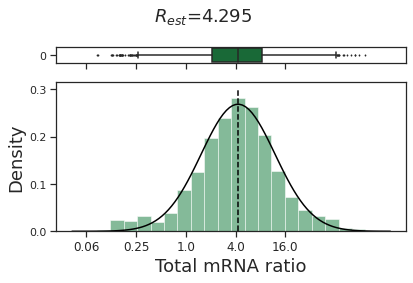

In [15]:
r_list = tm.infer.ratio_2types(adata_dbl_mg, output='./tomas/output/Tcells')#'./prepareForRepo/re_test/test')
#np.savetxt('./tomas/output/Tcells/Homo-naive_Homo-activated_dbl_Rest.txt',r_list)
#r_list = np.loadtxt('./prepareForRepo/re_test/test/rest.txt')
tm.vis.logRatio_dist(r_list)#, return_fig=True)


Display the total UMI distribution with raw data and ratio-based corrected data. The corrected distribution should reflect the truth of total mRNA ratio between cell types.

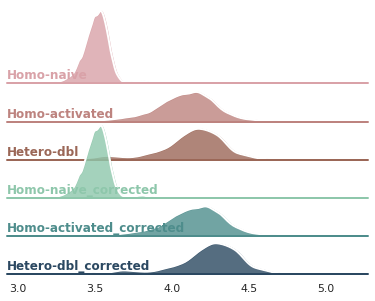

In [16]:
tm.vis.corrected_UMI_hist(adata,
                          groupby = 'danno',
                          groups = ['Homo-naive','Homo-activated','Hetero-dbl'],
                          reference = 'Homo-naive',
                          logUMIby = 'log10_totUMIs',
                          ratios = [1,4.3,5.3])

In [ ]:
adata.write_h5ad('./tomas/output/Tcells/adata_all.h5ad')
